In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
# from collections import OrderedDict
%matplotlib inline

import torchvision.transforms as transforms

In [2]:
# 계층적인 폴더 구조를 갖고 있는 데이터셋을 불러올때 사용 : 폴더 이름 = 클래스 명
from torchvision.datasets import ImageFolder

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
torch.__version__

'1.7.1+cu110'

In [5]:
# another
dataset = ImageFolder('data/Images')

test_pct = 0.2
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

train, val, test = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# custom Dataset
class DogData(Dataset) :
    def __init__(self, ds, transform = None) :
        self.ds = ds
        self.transform = transform
    
    def __len__(self) :
        return len(self.ds)
    
    def __getitem__(self, idx) :
        img, label = self.ds[idx]
        if self.transform :
            img = self.transform(img)
            return img, label

        
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225]) 
                                      ])

val_transforms = transforms.Compose([
                                     transforms.Resize(255), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                     transforms.Resize(255), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


train = DogData(train, train_transforms)
val = DogData(val, val_transforms)
test = DogData(test, test_transforms)


num_workers = 0
batch_size = 8

trainLoader = torch.utils.data.DataLoader(train, batch_size=batch_size, 
                                              num_workers=num_workers, shuffle=True)
valLoader = torch.utils.data.DataLoader(val, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
testLoader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                             num_workers=num_workers, shuffle=True)

In [8]:
from torchvision.models import resnet152

In [10]:
resnet = resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to C:\Users\jinma/.cache\torch\hub\checkpoints\resnet152-b121ed2d.pth


In [35]:
class Resnet(nn.Module):
    
    def __init__(self, resnet, n_classes, freeze=True):
        super().__init__()
        self.resnet = resnet
        if freeze:
            for param in resnet.parameters():
                param.requires_grad = False
        n_inputs = self.resnet.fc.out_features # 1000
        # 학습시킬 파라미터
        self.fc1 = nn.Linear(n_inputs, 1024)
        self.fc2 = nn.Linear(1024, n_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = torch.relu(self.fc1(x))
        return torch.relu(self.fc2(x))

In [36]:
model = Resnet(resnet, 120).to(device)

In [38]:
x = torch.randn(1, 3, 240, 240) # sample example
model(x).size()

torch.Size([1, 120])

In [40]:
import torch.optim as optim

In [41]:
# learning rate를 단계적으로 줄여주는 방법
# epoch 100 -> lr/10, 150 -> lr/10
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### Train & validation

In [44]:
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)
# hyper-parameters
num_epochs = 200
num_batches = len(trainLoader)

In [ ]:
trn_loss_list = []
val_loss_list = []
for epoch in tqdm(range(num_epochs)):
    adjust_learning_rate(optimizer,epoch)
    trn_loss = 0.0
    for i, data in enumerate(trainLoader):
        x, label = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        model_output = model(x)
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
        
        trn_loss += loss.item()
        
        if (i+1) % 100 == 0: # every 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                corr_num = 0
                total_num = 0
                for j, val in enumerate(valLoader):
                    val_x, val_label = val[0].to(device), val[1].to(device)
                    val_output = model(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    
                    model_label = val_output.argmax(dim=1)
                    corr = val_label[val_label == model_label].size(0)
                    corr_num += corr
                    total_num += val_label.size(0)
            
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | acc: {:.2f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(valLoader), (corr_num / total_num) * 100
            ))            
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(valLoader))
            trn_loss = 0.0

print("training finished!")

epoch: 1/200 | step: 100/213 | trn loss: 3.1990 | val loss: 1.6741 | acc: 61.38
epoch: 1/200 | step: 200/213 | trn loss: 2.1422 | val loss: 1.3982 | acc: 65.08
epoch: 2/200 | step: 100/213 | trn loss: 2.1581 | val loss: 1.9505 | acc: 65.61
epoch: 2/200 | step: 200/213 | trn loss: 2.0666 | val loss: 1.4866 | acc: 70.90
epoch: 3/200 | step: 100/213 | trn loss: 2.0732 | val loss: 1.3472 | acc: 68.25
epoch: 3/200 | step: 200/213 | trn loss: 2.1986 | val loss: 0.9562 | acc: 75.13
epoch: 4/200 | step: 100/213 | trn loss: 2.0971 | val loss: 0.7951 | acc: 83.07
epoch: 4/200 | step: 200/213 | trn loss: 2.3621 | val loss: 1.2746 | acc: 76.19
epoch: 5/200 | step: 100/213 | trn loss: 1.9314 | val loss: 1.5200 | acc: 71.96
epoch: 5/200 | step: 200/213 | trn loss: 2.1156 | val loss: 1.9289 | acc: 69.84
epoch: 6/200 | step: 100/213 | trn loss: 2.2584 | val loss: 1.2693 | acc: 79.37
epoch: 6/200 | step: 200/213 | trn loss: 2.3773 | val loss: 1.7757 | acc: 67.72
epoch: 7/200 | step: 100/213 | trn loss:

epoch: 52/200 | step: 100/213 | trn loss: 1.7494 | val loss: 0.9570 | acc: 80.42
epoch: 52/200 | step: 200/213 | trn loss: 1.5801 | val loss: 0.9750 | acc: 84.13
epoch: 53/200 | step: 100/213 | trn loss: 1.9504 | val loss: 1.4693 | acc: 78.31
epoch: 53/200 | step: 200/213 | trn loss: 1.6748 | val loss: 0.8334 | acc: 85.71
epoch: 54/200 | step: 100/213 | trn loss: 1.4421 | val loss: 1.2895 | acc: 76.19
epoch: 54/200 | step: 200/213 | trn loss: 1.7418 | val loss: 1.0207 | acc: 83.07
epoch: 55/200 | step: 100/213 | trn loss: 1.5274 | val loss: 1.1508 | acc: 81.48
epoch: 55/200 | step: 200/213 | trn loss: 1.8337 | val loss: 1.2878 | acc: 78.84
epoch: 56/200 | step: 100/213 | trn loss: 1.6667 | val loss: 1.1789 | acc: 82.01
epoch: 56/200 | step: 200/213 | trn loss: 1.6767 | val loss: 1.1211 | acc: 83.07
epoch: 57/200 | step: 100/213 | trn loss: 1.6642 | val loss: 0.8923 | acc: 80.42
epoch: 57/200 | step: 200/213 | trn loss: 1.7361 | val loss: 0.7928 | acc: 84.13
epoch: 58/200 | step: 100/21

epoch: 103/200 | step: 100/213 | trn loss: 1.0687 | val loss: 0.5015 | acc: 87.83
epoch: 103/200 | step: 200/213 | trn loss: 1.1454 | val loss: 0.4980 | acc: 89.42
epoch: 104/200 | step: 100/213 | trn loss: 1.1706 | val loss: 0.7431 | acc: 84.13
epoch: 104/200 | step: 200/213 | trn loss: 1.1140 | val loss: 0.7893 | acc: 80.95
epoch: 105/200 | step: 100/213 | trn loss: 1.1648 | val loss: 0.7651 | acc: 83.07
epoch: 105/200 | step: 200/213 | trn loss: 1.0292 | val loss: 0.7609 | acc: 83.60
epoch: 106/200 | step: 100/213 | trn loss: 1.1740 | val loss: 0.5078 | acc: 88.89
epoch: 106/200 | step: 200/213 | trn loss: 1.1281 | val loss: 0.5436 | acc: 87.83
epoch: 107/200 | step: 100/213 | trn loss: 1.1011 | val loss: 0.5454 | acc: 89.95
epoch: 107/200 | step: 200/213 | trn loss: 1.0723 | val loss: 0.5693 | acc: 88.36
epoch: 108/200 | step: 100/213 | trn loss: 1.0718 | val loss: 0.5321 | acc: 86.24
epoch: 108/200 | step: 200/213 | trn loss: 1.0150 | val loss: 0.5115 | acc: 87.83
epoch: 109/200 |

In [ ]:
# save
PATH = "./vgg19.pt"
torch.save(vgg16.state_dict(), PATH)

print("model saved!")

In [19]:
# test acc
with torch.no_grad():
    corr_num = 0
    total_num = 0
    for j, val in enumerate(testLoader):
        val_x, val_label = val
        val_x = val_x.to(device)
        val_label =val_label.to(device)
        val_output = vgg16(val_x)
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)

print("test_acc: {:.2f}".format(corr_num / total_num * 100))

test_acc: 66.84


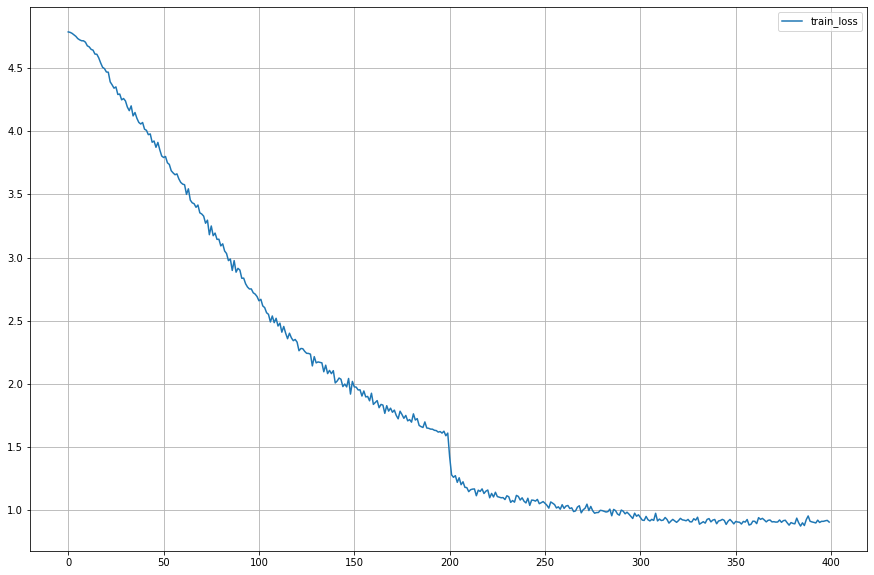

In [31]:
plt.figure(figsize = (15,10))
plt.plot(trn_loss_list, label="train_loss")
plt.legend()
plt.grid('on')
plt.show()